# Projeto - Visão Computacional 

<br>

#### Implementação do artigo [Predicting Biomechanical Risk Factors for Division - I Women’s Basketball Athletes](https://ieeexplore.ieee.org/document/10887636)
##### Feito por Lucas Paiva Ferruccio
---

#### • Imports

In [5]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

res_testes = (480, 854)
res_display = (640,480)
res_yolo = (640,640)

video_path = "data/testes/videoTesteFrontal.mp4"

### Funções Auxiliares:

#### • Criar vetores


In [6]:
"""
Recebe dois pontos A e B e retorna o vetor AB
"""
def create_vector(A, B):
    return np.array(B) - np.array(A)

#### • Distância Euclidiana

In [8]:
"""
Calcula a distancia entre os pontos A e B
"""
def dist_euclidiana(A, B):
    return np.linalg.norm(create_vector(A,B))

#### • Calculo do ponto médio

In [9]:
def mid_point(A, B):
    A = np.array(A)
    B = np.array(B)
    
    return np.divide(np.add(A, B), 2)

#### • Calculo do angulo entre dois vetores

In [10]:
"""
    Calcula o angulo (em Grau) entre dois vetores usando o arccos dos vetores A e B
    Ang = arccos(A.B/|A|x|B|)
"""
def calculate_angle_arrays(A, B):
    # Norma dos vetores
    mod_A = np.linalg.norm(A)
    mod_B = np.linalg.norm(B)
    
    # Produto escalar
    dot_AB = np.dot(A, B)
    
    # Calculo do angulo em radiano
    rdn = np.arccos(dot_AB / (mod_A * mod_B))
    
    # Conversão para grau
    return np.degrees(rdn)
    

### Calculo dos pontos de riscos

#### • Flexão Lateral do Tronco
 • Cálculo do grau de desvio lateral do tronco utilizando o ponto médio do quadril (23,24) e o ponto médio do ombro (11,12)

In [15]:
# python
def risk_lateral_trunk(landmarks, image_bgr=None, res=res_testes, draw=True):
    try:
        # coordenadas normalizadas (x,y)
        left_sh = np.array([landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x,
                            landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y])
        right_sh = np.array([landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x,
                             landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y])
        left_hip = np.array([landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                             landmarks[mp_pose.PoseLandmark.LEFT_HIP].y])
        right_hip = np.array([landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x,
                              landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y])
    except Exception:
        return False, 0.0

    # pontos médios em coordenadas normalizadas
    mid_sh = mid_point(left_sh, right_sh)
    mid_hp = mid_point(left_hip, right_hip)

    # dimensão em pixels: preferir a imagem se passada, senão usar res
    if image_bgr is not None:
        h, w = image_bgr.shape[:2]
    else:
        w, h = int(res[0]), int(res[1])

    # converte para pixels
    mid_sh_px = (int(mid_sh[0] * w), int(mid_sh[1] * h))
    mid_hp_px = (int(mid_hp[0] * w), int(mid_hp[1] * h))
    mid_top_px = (w // 2, 0)

    # vetores com origem em mid_hip (pixels)
    trunk_vec = np.array([mid_sh_px[0] - mid_hp_px[0], mid_sh_px[1] - mid_hp_px[1]])
    base_vec = np.array([mid_top_px[0] - mid_hp_px[0], mid_top_px[1] - mid_hp_px[1]])

    # cálculo de ângulo (graus)
    try:
        angle = float(calculate_angle_arrays(base_vec, trunk_vec))
    except Exception:
        return False, 0.0

    detected = np.isfinite(angle)

    # desenha na imagem (in-place) se solicitado
    if draw and image_bgr is not None and detected:
        cv2.circle(image_bgr, mid_hp_px, 6, (0, 0, 255), -1)
        cv2.circle(image_bgr, mid_sh_px, 6, (255, 0, 0), -1)
        cv2.arrowedLine(image_bgr, mid_hp_px, mid_sh_px, (255, 0, 0), 2, tipLength=0.2)
        cv2.arrowedLine(image_bgr, mid_hp_px, mid_top_px, (0, 255, 0), 2, tipLength=0.2)
        text_pos = (mid_hp_px[0] + 10, mid_hp_px[1] - 10)
        cv2.putText(image_bgr, f"{angle:.1f} deg", text_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,255), 2)

    return detected, angle


#### • Testes 

In [13]:
# Roda um video

cap_video = cv2.VideoCapture(video_path)

while cap_video.isOpened():
    ret, frame1 = cap_video.read()
    
    frame_resized = cv2.resize(frame1, res_testes)
    
    cv2.imshow('Pose Tracking (Pressione Q para sair)', frame_resized)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap_video.release()
cv2.destroyAllWindows()


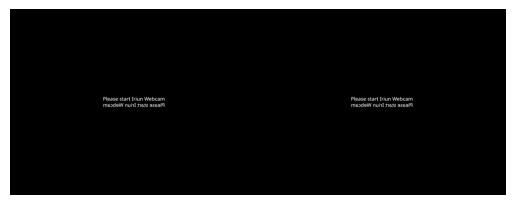

In [14]:
# Concatena dois frames
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
ret2, frame2 = cap.read()

cap.release()

img_dupla = cv2.hconcat([frame, frame2])

image = cv2.cvtColor(img_dupla, cv2.COLOR_BGR2RGB)

plt.axis('off')
plt.imshow(image)

In [15]:
# Captura de video

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    cv2.imshow('Pose Tracking (Pressione Q para sair)', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

In [16]:
!python --version

Python 3.10.18


In [16]:
# Configurando o mediapipe
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

cap = cv2.VideoCapture(video_path)

"""

min_detection_confidence -> Define a porcentagem de confiança de detecção de uma pessoa

min_tracking_confidence -> Define a porcentagem de confiança de detecção dos pontos do corpo

"""
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        frame1 = cv2.resize(frame, res_testes)
        
        # CONVERTE para RGB (Formato do MediaPipe)
        image = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
        # Protecao dos dados e otimizacao
        image.flags.writeable = False
        
        # PROCESSAMENTO
        results = pose.process(image)
        
        image.flags.writeable = True
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
         
        # Extrai as marcações
        try:
            landmarks = results.pose_landmarks.landmark
        except:
            pass
        
        # DESENHA os landmarks na imagem RGB
        mp_drawing.draw_landmarks(image_bgr, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                                  mp_drawing.DrawingSpec(color=(230, 255, 0), thickness=2, circle_radius=2)
                                  )
        
        print(risk_lateral_trunk(landmarks, image_bgr=image_bgr, res=res_testes, draw=True))
        
        # Exibe o frame
        cv2.imshow('Pose Tracking (Pressione Q para sair)', image_bgr)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
    cap.release()
    cv2.destroyAllWindows()

(True, 4.337115645611171)
(True, 4.558516996713466)
(True, 4.9320700434810405)
(True, 5.036682793779915)
(True, 5.160326611496742)
(True, 5.14440252714958)
(True, 5.5311566706265065)
(True, 5.654729069753152)
(True, 5.778280749901448)
(True, 6.041298177497772)
(True, 6.041298177497772)
(True, 6.16482799514937)
(True, 6.147941529527769)
(True, 6.192587519933211)
(True, 6.192587519933211)
(True, 6.192587519933211)
(True, 5.912527921657649)
(True, 6.051481521114218)
(True, 5.788464093517837)
(True, 5.664378117749126)
(True, 5.381891021298979)
(True, 4.85758024632201)
(True, 4.609882332800047)
(True, 4.2088826024736665)
(True, 3.824024332121862)
(True, 3.5767217113518)
(True, 3.329363747984714)
(True, 3.081959646862117)
(True, 2.5977092880664543)
(True, 2.0956423941509628)
(True, 1.97162691109204)
(True, 1.7235936208968938)
(True, 1.3357794427054328)
(True, 1.2117662836585283)
(True, 0.6839785187942423)
(True, 0.5561971287858007)
(True, 0.4324598816667117)
(True, 0.16970339456123326)
(True

In [ ]:
for lndmrk in mp_pose.PoseLandmark:
    print(lndmrk)


In [12]:
landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value]

x: 0.867439
y: 1.70486939
z: -0.193441406
visibility: 0.00138551579

In [13]:
print(mp_pose.PoseLandmark.LEFT_KNEE.value)

25


## Joints Map
![Joint Maps](https://www.researchgate.net/publication/361071987/figure/fig2/AS:11431281214731862@1703733107226/33-Landmarks-detected-on-the-human-body-using-MediaPipe.png)